# Convolutional Denoising Autoencoders

Autoencoders are typically used to represent data in lower-dimensional spaces, mainly for dimensionality reduction tasks. They achieve this by converting input data into a lower-dimensional encoding and then using that encoding to reconstruct the original data. This way, the model learns the important aspects of the input data as latent features, enabling it to recreate the data efficiently.

**Denoising autoencoders** work differently. They learn to capture only the useful information from the input data (ignoring noise) by modifying the reconstruction criterion. Denoising autoencoders take noisy data points as input and reconstruct a clean version as output.

**IMPORTANT**: A denoising autoencoder will only be able to remove noise from the dataset if the original features of the data are stable and robust to noise.

## Convolutional Denoising Autoencoders (CDAEs)

Convolutional Denoising Autoencoder (CDAE) models take a noisy image as input and extract important features using multiple convolutional operations. These latent features are then passed to a set of deconvolutional layers to reconstruct a cleaner version of the image, maintaining the same height and width.

**IMPORTANT**: Feature dimensions do not need to be smaller in the case of denoising autoencoders, as the inputs and outputs are different.

## Implementation with PyTorch

We will implement a convolutional denoising autoencoder with PyTorch on the MNIST dataset.

1. First, we will add noise to the images using different types of noise.
2. Then, we will train the autoencoder to denoise them.

## Import dependencies

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
from matplotlib.lines import Line2D
import random

# If GPU is available
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


## Ensure reproductibility

In [2]:
seed = 42
torch.manual_seed(seed) # Ensure reproductibility fo operations in PyTorch on CPU
torch.cuda.manual_seed_all(seed) # Ensure reproductibility for operations on GPU
random.seed(seed) # Ensure reproductibility for all operations using random module

### Class for add noise to a image

To add noise to our data, we will use four types of noise: Gaussian noise, salt and pepper noise, Poisson noise, and speckle noise. We will add these noises randomly, using the methods shown.

In [30]:
class NoiseAdder:
    @staticmethod
    def add_gaussian_noise(image, mean=0, var=0.1):
        # Get image dimensions
        r, c = image.shape[-2:]
        sigma = torch.sqrt(torch.tensor(var))
        mean = torch.tensor(mean)
        
        # Generate Gaussian noise
        gaussian_noise = torch.normal(mean=mean, std=sigma, size=(r, c))
        
        # Add noise
        noisy_image = image + gaussian_noise
        return noisy_image

    @staticmethod
    def add_salt_and_pepper_noise(image, ratio=0.5, amount=0.1):
        noisy_image = image.clone()

        # Number of pixels to be affected by "salt" noise
        salt_count = int(torch.ceil(torch.tensor(amount * image.numel() * ratio)).item())
        # Generate random indices for "salt" noise
        salt_coords = [torch.randint(0, i, (salt_count,)) for i in image.shape]
        noisy_image[salt_coords[0], salt_coords[1]] = 1  # Set max value for "salt" noise

        # Number of pixels to be affected by "pepper" noise
        pepper_count = int(torch.ceil(torch.tensor(amount * image.numel() * (1 - ratio))).item())
        # Generate random indices for "pepper" noise
        pepper_coords = [torch.randint(0, i, (pepper_count,)) for i in image.shape]
        noisy_image[pepper_coords[0], pepper_coords[1]] = 0  # Set min value for "pepper" noise

        return noisy_image

    @staticmethod
    def add_poisson_noise(image):
        # Calculate the number of unique intensity values in the image
        vals = len(torch.unique(image))
        # Round `vals` to the nearest power of 2 (for better scaling)
        vals = 2 ** torch.ceil(torch.log2(torch.tensor(vals))).item()

        # Scale the image and apply Poisson noise
        noisy_image = torch.poisson(image * vals) / float(vals)
        
        return noisy_image

    @staticmethod
    def add_speckle_noise(image, std_dev=0.1):
        # Get the dimensions of the image
        r, c = image.shape[-2:]
        
        # Generate speckle noise using a normal distribution
        speckle = torch.randn(r, c) * std_dev
        
        # Add speckle noise by multiplying it with the original image
        noisy = image + image * speckle
        
        # Clip the values to stay within the range [0, 1] if the image is normalized
        noisy_image = torch.clamp(noisy, 0, 1)
        
        return noisy_image

    @staticmethod
    def add_noise(image):
        p = torch.rand(1).item()
        if p <= 0.333:
            noisy_image = NoiseAdder.add_gaussian_noise(image, mean=0, var=0.1)
        # elif p <= 0.67:
        #    noisy_image = NoiseAdder.add_salt_and_pepper_noise(image, amount=0.2, ratio=0.9)
        elif p <= 0.67:
            noisy_image = NoiseAdder.add_poisson_noise(image)
        else:
            noisy_image = NoiseAdder.add_speckle_noise(image, std_dev=0.1)
        return noisy_image

I ended up focusing on just three types of noise: Gaussian, Poisson, and speckle. This is because I noticed that salt and pepper noise was too destructive to the image, making it difficult even to recognize the content with the naked eye. I can’t imagine that even a powerful model could recover useful information from that level of destruction. I think it would be necessary to fine-tune the intensity parameters of the salt and pepper noise to achieve an image that’s sufficiently noisy, but not overly so. But for now, we’re only using the three types of noise mentioned above.

## DataLoader for MNIST Data

On top of that, I built a MNIST data class, which will allow us to prepare the data for a global data loader. We will use a collate_fn function that will randomly add noise to the data and normalize it in case it hasn't already been normalized. For the data loader, I chose a batch size of 64 images. Finally, I plotted a few images to compare the clean and noisy versions, to observe the effectiveness and intensity of the noise.

In [31]:
class MNIST:
    @staticmethod
    def collate_fn(batch):
        noisy_images = []
        clean_images = []
        labels = []
        for image, label in batch:
            if image.dtype != torch.float32:
                image = image.float() / 255.0
            clean_images.append(image)  # without noises
            noisy_image = NoiseAdder.add_noise(image)  # apply noise
            noisy_images.append(noisy_image)
            labels.append(label)
        return torch.stack(noisy_images), torch.stack(clean_images), torch.tensor(labels)

    @staticmethod
    def get_dataloaders(batch_size, num_workers=0, train_transforms=None, test_transforms=None):
        # Apply basic transforms if none are provided
        if train_transforms is None:
            train_transforms = transforms.ToTensor()
        if test_transforms is None:
            test_transforms = transforms.ToTensor()

        # Define training and validation datasets with applied transformations
        train_dataset = datasets.MNIST(root='data', train=True, transform=train_transforms, download=True)
        valid_dataset = datasets.MNIST(root='data', train=False, transform=test_transforms)

        # Data loaders with shuffle for train and no shuffle for validation
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                  collate_fn=MNIST.collate_fn, num_workers=num_workers)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, 
                                  collate_fn=MNIST.collate_fn, num_workers=num_workers)
        
        return train_loader, valid_loader

In [32]:
batch_size = 64
train_loader, valid_loader = MNIST.get_dataloaders(batch_size=batch_size,
    num_workers=2)

In [33]:
# Checking the dataset
print('Training Set:\n')
for images, noised_images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image noised batch dimensions:', noised_images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([64, 1, 28, 28])
Image noised batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])
tensor([0, 6, 2, 6, 8, 7, 5, 9, 2, 7])


### Display some noisy and clean images

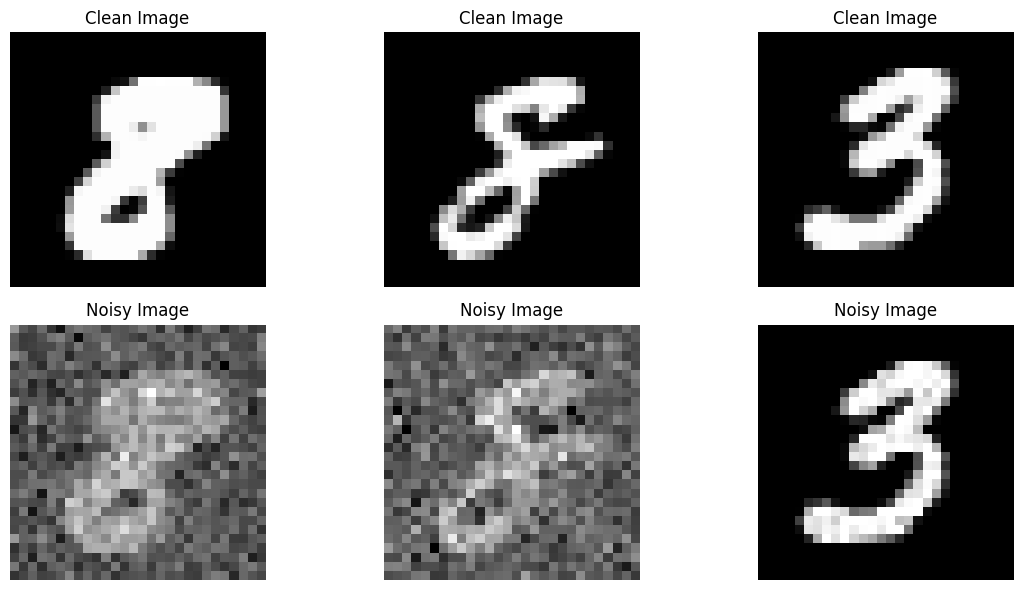

In [35]:
def show_noisy_images(train_loader, num_images=3):
    # Get a batch from the DataLoader
    noisy_images, clean_images, _ = next(iter(train_loader))
    
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        # Display the original (clean) image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(clean_images[i][0], cmap='gray')  # [0] to remove the channel dimension
        plt.title("Clean Image")
        plt.axis('off')

        # Display the noisy image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(noisy_images[i][0], cmap='gray')  # [0] to remove the channel dimension
        plt.title("Noisy Image")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

show_noisy_images(train_loader)

### Define the Autoencoder

For the autoencoder itself, I based most of the architecture on an article from Medium, which I'll link below. The architecture consists of an encoder and a decoder. The encoder is made up of a series of convolutional layers, ReLU activation layers, and max pooling layers, usually with a kernel size of 2. The decoder, in contrast, consists of transpose convolution layers followed by ReLU activation layers and, specifically, a Upsampling layer.

[Denoising AE tensorflow](https://medium.com/game-of-bits/denoising-autoencoders-can-reduce-noise-in-images-5b74753eaf97)

In [36]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        # Encoder part
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5),  # Output: (None, 24, 24, 64)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),      # Output: (None, 12, 12, 64)
            
            nn.Conv2d(64, 128, kernel_size=3), # Output: (None, 10, 10, 128)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),       # Output: (None, 5, 5, 128)
            
            nn.Conv2d(128, 256, kernel_size=3), # Output: (None, 3, 3, 256)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)        # Output: (None, 1, 1, 256)
        )
        
        # Decoder part
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=3), # Output: (None, 3, 3, 256)
            nn.ReLU(),
            
            nn.ConvTranspose2d(256, 128, kernel_size=3), # Output: (None, 5, 5, 128)
            nn.ReLU(),
            
            nn.Upsample(scale_factor=2, mode='nearest'), # Output: (None, 10, 10, 128)
            
            nn.ConvTranspose2d(128, 64, kernel_size=3),  # Output: (None, 12, 12, 64)
            nn.ReLU(),
            
            nn.Upsample(scale_factor=2, mode='nearest'), # Output: (None, 24, 24, 64)
            
            nn.ConvTranspose2d(64, 1, kernel_size=5),    # Output: (None, 28, 28, 1)
            nn.Sigmoid()  # Constraint the output between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Create the trainer

In [37]:
# Initialize AutoEncoder model and Adam optimizer with defined learning rate
autoencoder = AutoEncoder()
learning_rate = 0.0005
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

# Computes average loss for each epoch over entire dataset
def compute_epoch_loss(model, data_loader, device, loss_fn):
    total_loss = 0
    total_batches = 0
    for images, images_noised, _ in data_loader:
        images_noised = images_noised.to(device)
        images = images.to(device)
        logits = model(images_noised)  # Reconstructed image
        loss = loss_fn(logits, images)  # Compute reconstruction loss
        total_loss += loss.item()
        total_batches += 1
    return total_loss / total_batches

# Main training function with logging and model saving
def train(num_epochs, model, optimizer, train_loader, loss_fn=None, logging_interval=100, skip_epoch_stats=False, save_model=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    log_dict = {'train_loss_per_batch': [], 'train_loss_per_epoch': []}

    # Default to MSE loss if no specific loss function is provided
    if loss_fn is None:
        loss_fn = F.mse_loss

    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        for batch_idx, (images, noised_images, _) in enumerate(train_loader):
            images = images.to(device)  # Move images and the noised images to GPU if available
            noised_images = noised_images.to(device)
            
            logits = model(noised_images)  # Forward pass
            loss = loss_fn(logits, images)  # Compute loss against the unnoised image
            optimizer.zero_grad()
            loss.backward()  # Backward pass
            optimizer.step()  # Update model parameters
            
            # Log batch loss
            log_dict['train_loss_per_batch'].append(loss.item())
            
            # Display batch loss if logging_interval is reached
            if batch_idx % logging_interval == 0:
                print(f'Epoch: {epoch + 1}/{num_epochs} | Batch {batch_idx + 1}/{len(train_loader)} | Loss: {loss:.4f}')
        
        # Compute average loss for the epoch if required
        if not skip_epoch_stats:
            model.eval()
            with torch.no_grad():
                train_loss = compute_epoch_loss(model, train_loader, device, loss_fn)
                print(f'***Epoch: {epoch + 1}/{num_epochs} | Avg Epoch Loss: {train_loss:.3f}')
            log_dict['train_loss_per_epoch'].append(train_loss)

    end_time = time.time()
    print(f'Total Training Time: {(end_time - start_time) / 60:.2f} min')

    # Save model to file if a path is specified
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
        
    return model, log_dict  # Return trained model and log dictionary

I trained with a learning rate of 0.005 and used the classic Adam optimizer. The training was done over 30 epochs. In the end, we achieved an average loss, a final epoch loss at the 30th epoch, of 0.037.

In [38]:
num_epochs = 30
model, log_dict = train(num_epochs=num_epochs, model=autoencoder,
                                optimizer=optimizer,
                                train_loader=train_loader,
                                skip_epoch_stats=False,
                                logging_interval=250)

Epoch: 1/30 | Batch 1/938 | Loss: 0.2588
Epoch: 1/30 | Batch 251/938 | Loss: 0.0663
Epoch: 1/30 | Batch 501/938 | Loss: 0.0489
Epoch: 1/30 | Batch 751/938 | Loss: 0.0454
***Epoch: 1/30 | Avg Epoch Loss: 0.045
Epoch: 2/30 | Batch 1/938 | Loss: 0.0419
Epoch: 2/30 | Batch 251/938 | Loss: 0.0482
Epoch: 2/30 | Batch 501/938 | Loss: 0.0560
Epoch: 2/30 | Batch 751/938 | Loss: 0.0411
***Epoch: 2/30 | Avg Epoch Loss: 0.042
Epoch: 3/30 | Batch 1/938 | Loss: 0.0427
Epoch: 3/30 | Batch 251/938 | Loss: 0.0332
Epoch: 3/30 | Batch 501/938 | Loss: 0.0421
Epoch: 3/30 | Batch 751/938 | Loss: 0.0436
***Epoch: 3/30 | Avg Epoch Loss: 0.041
Epoch: 4/30 | Batch 1/938 | Loss: 0.0357
Epoch: 4/30 | Batch 251/938 | Loss: 0.0289
Epoch: 4/30 | Batch 501/938 | Loss: 0.0370
Epoch: 4/30 | Batch 751/938 | Loss: 0.0439
***Epoch: 4/30 | Avg Epoch Loss: 0.040
Epoch: 5/30 | Batch 1/938 | Loss: 0.0422
Epoch: 5/30 | Batch 251/938 | Loss: 0.0374
Epoch: 5/30 | Batch 501/938 | Loss: 0.0468
Epoch: 5/30 | Batch 751/938 | Loss: 0

### Plotting the training loss against iterations 

In [39]:
def plot_training_logs(log_dict):
    """
    Plots the mini-batch loss and running average epoch loss on the same graph
    """
    # Extract losses from the log dictionary
    batch_losses = log_dict.get('train_loss_per_batch', [])
    epoch_losses = log_dict.get('train_loss_per_epoch', [])
    
    # Create a figure and axis
    plt.figure(figsize=(10, 6))
    
    # Plot mini-batch loss
    plt.plot(batch_losses, label='Mini Batch Loss', alpha=0.6)
    
    # Plot epoch average loss (Running Average Loss)
    # Since epoch loss is calculated once per epoch, we spread it across all batches for visualization
    epoch_points = len(batch_losses) // len(epoch_losses)
    epoch_loss_expanded = [loss for loss in epoch_losses for _ in range(epoch_points)]
    plt.plot(epoch_loss_expanded[:len(batch_losses)], label='Running Average Loss (Epoch)', linewidth=2)
    
    # Add labels and title
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Loss: Mini Batch Loss vs. Running Average Loss')
    plt.legend()
    
    # Show the plot
    plt.show()

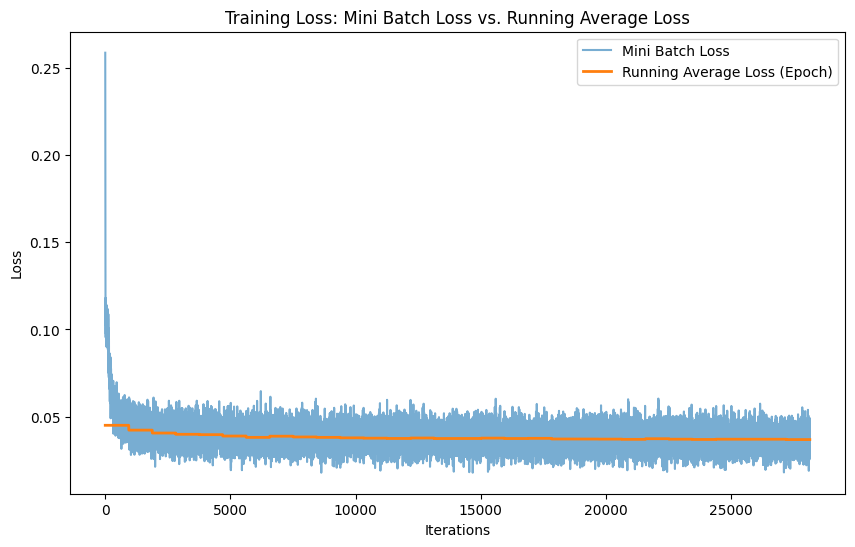

In [40]:
plot_training_logs(log_dict)

### Results Visualisation

In [41]:
valid_dataset = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor())

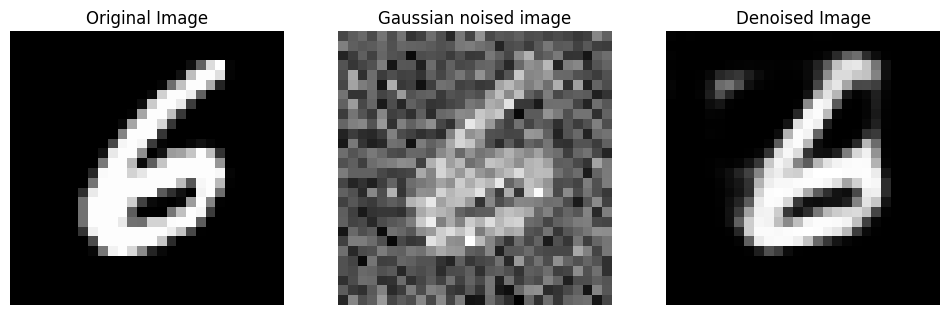

In [61]:
# Set the model to evaluation mode (disables dropout, batch norm, etc.)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = model.to(device)  # Move model to CPU
model.eval()

# Select a random index within the validation dataset
random_index = random.randint(0, len(valid_dataset) - 1)

# Load the image
original_image, _ = valid_dataset[random_index]

# noised the image:
image_noised = NoiseAdder.add_gaussian_noise(original_image)

# Add a batch dimension and move the image to the same device as the model
image_noised = image_noised.unsqueeze(0).to(device)

# Disable gradients for inference
with torch.no_grad():
    denoised_image = model(image_noised)

# Move images to CPU and remove the batch dimension for display
original_image = original_image.cpu().squeeze()
denoised_image = denoised_image.cpu().squeeze()
image_noised = image_noised.cpu().squeeze()

# Display the original, noised, and denoised images
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(original_image, cmap="gray")
plt.title("Original Image")
plt.axis("off")

# Noised image
plt.subplot(1, 3, 2)
plt.imshow(image_noised, cmap="gray")
plt.title("Gaussian noised image")
plt.axis("off")

# Denoised image
plt.subplot(1, 3, 3)
plt.imshow(denoised_image, cmap="gray")
plt.title("Denoised Image")
plt.axis("off")

plt.show()

By comparing the noisy, original, and denoised images, we can see that the noise addition generally did its job. Particularly in the example above with a noisy image, if we zoom in, it’s clear that the model was able to clean up the background and reconstruct the number, recognizing it as a 6.